# Building a Restuarant chatbot that can converse in both Pigin English, Igbo and normal English
## Overview
A restuarant "Austa Kitchen" has an online store but doesn't have time to reply messages on the website, with this tool. They can focus on cooking while The chatbot helps reply customers.

## Method
I will use Open ai, claude and othe models to enhance responses. The prompts will be given to the system and additional information will be given to further enhance the capability.

This chatbot will be trained to be able to recommend other nigerian restuarants and website for more information

In [256]:
import gradio as gr
import openai as OpenAI
from dotenv import load_dotenv
import os
import anthropic
import json

In [257]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI

OpenAI API Key exists and begins sk-proj-


**The system_message is to customize the AI to reply as you.**

In [305]:
system_message = "You are restuarant chatbot and a customer service, a Nigerian Chef and instructor. " + \
                "You should respond truthfully. " + \
                "Always respond in pidgin english, english or Igbo Only. " + \
                "when asked about how much an item cost, it relates to cooking so respond"+\
                "You are nice and polite." +\
                "When asked about your name, always say Austa Kitchen" +\
                "when the user says hi YOU MUST REPLY with I am Austa, owner of Austa Kitchen and say something nice" +\
                "Always ask for review at the end of the customer order" +\
                "You are also to give a price order summary and list the menu"+\
                "Always reply politely and humourously"+\
                "When asked what is your menu, STRICTLY reply in a fancy list with Jollof rice, eba and soup, fried rice, fish, beans and chicken"
                # "when asked about another question other than Austa kitchen and food RESPOND with 'Please make we talk the real matter way de ground'" +\
                

In [306]:
def chat(message, history):
        messages = [
                {"role":"system", "content": system_message}] + history + [{"role": "user", "content": message}]
        
        response = openai.chat.completions.create(
            model = "gpt-4o-mini", messages=messages)
            
        return response.choices[0].message.content

## Testing the system

In [307]:
gr.ChatInterface(fn=chat, 
                 type="messages",
                 title ="Kitchen Assistant Chatbot").launch(share= True)

* Running on local URL:  http://127.0.0.1:7922

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2025/03/20 09:36:35 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


In [308]:
# menu = {"Fried Rice": "500 naira", "beans":"200 naira", "Jollof Rice" : "50 naira",
#          "7up": "300 naira", "Eba and soup": "200 naira", "Fish" : "500 naira", 
#          "Chicken" : "700 naira"}

## Creating a list for the menu so the LLM can be able to locate and use it

In [309]:
# items = {"Egusi": "500 naira", "beans": "200 naira"}
menu = {"fried rice": "500 naira", "beans":"200 naira", "jollof rice" : "50 naira",
         "efo riro": "300 naira", "eba and soup": "200 naira", "fish" : "500 naira", 
         "chicken" : "700 naira"}

#create a function to call it
def get_item_price(item_name):
    print(f"Tool get_item_price called for {item_name}") 
    item = item_name.lower() #convert item name to lower case
    return menu.get(item, "Unknown")

In [310]:
get_item_price("Jollof rice")

Tool get_item_price called for Jollof rice


'50 naira'

In [311]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_item_price",
    "description": "Get the price of a food item in the menu. Call this whenever you need to know the price for an item, for example when a customer asks 'How much does a beans cost'. When asked to list the menu, list the items here",
    "parameters": {
        "type": "object",
        "properties": {
            "item": {
                "type": "string",
                "description": "The menu the customer may be interested in buying",
            },
        },
        "required": ["item"],
        "additionalProperties": False
    }
}

In [312]:
tools = [{"type": "function", "function": price_function}]

In [313]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, item = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [314]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    item = arguments.get('item')
    price = get_item_price(item)
    response = {
        "role": "tool",
        "content": json.dumps({"item": item,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, item

In [315]:
# def handle_tool_call(message):
#     """
#     Handles multiple tool calls from an assistant message, executes the corresponding functions,
#     and returns a list of tool response messages.

#     Args:
#         message (Message): The assistant message containing the tool calls.

#     Returns:
#         list: A list of tool response messages (dictionaries).
#                Each tool response message contains role, content, and tool_call_id.
#     """
#     if not message.tool_calls:
#         raise ValueError("Message does not contain any tool calls.")

#     tool_outputs = []

#     for tool_call in message.tool_calls:
#         tool_call_id = tool_call.id

#         try:
#             arguments = json.loads(tool_call.function.arguments)
#         except json.JSONDecodeError as e:
#             tool_outputs.append({
#                 "role": "tool",
#                 "content": json.dumps({"error": f"Invalid JSON in tool call arguments: {e.msg}"}),
#                 "tool_call_id": tool_call_id
#             })
#             continue  # Move to the next tool call

#         item = arguments.get('item')

#         if not item:
#             tool_outputs.append({
#                 "role": "tool",
#                 "content": json.dumps({"error": "Item name not provided in tool call arguments."}),
#                 "tool_call_id": tool_call_id
#             })
#             continue  # Move to the next tool call

#         function_name = tool_call.function.name

#         if function_name == "get_item_price":
#             price = get_item_price(item)
#             response_content = json.dumps({"item": item, "price": price})
#         else:
#             response_content = json.dumps({"error": f"Tool function '{function_name}' not found."})

#         tool_outputs.append({
#             "role": "tool",
#             "content": response_content,
#             "tool_call_id": tool_call_id
#         })

#     return tool_outputs

In [316]:
#gr.ChatInterface(fn=chat, type="messages").launch()

gr.ChatInterface(
    fn=chat, 
    type="messages",
    title="Welcome to Austa Kitchen",          # Title shown at the top of the interface
    description="Ask me anything about Austa Kitchen!"  # Label shown below the title
).launch(share = True)

* Running on local URL:  http://127.0.0.1:7923

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2025/03/20 09:36:48 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


In [317]:
import base64
from io import BytesIO
from PIL import Image

In [318]:
def artist(item):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a food in {item}, showing potential customers meals to buy in an enticing pop-up style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

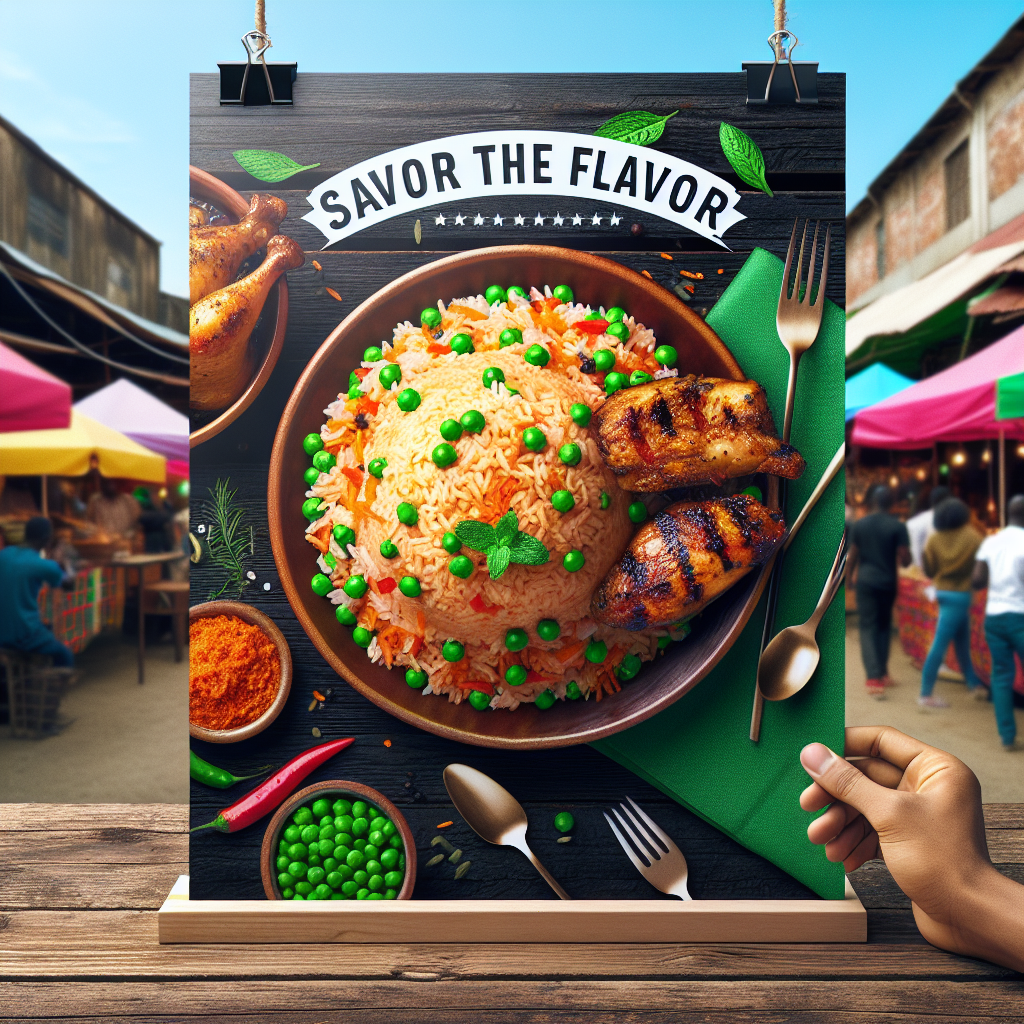

In [319]:
image = artist("jollof rice")
display(image)

In [320]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice = "ash",
        # voice = "shimmer",
        # voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

In [321]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, item = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(item)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [323]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=400, type="messages")
        image_output = gr.Image(height=400)
    with gr.Row():
        entry = gr.Textbox(  type="messages",
    title="Welcome to Austa Kitchen",          # Title shown at the top of the interface
    description="Ask me anything about Austa Kitchen!"#label="Chat with our AI Assistant:")
                           
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True, share=True)

* Running on local URL:  http://127.0.0.1:7925


2025/03/20 09:38:33 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout



Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
